# Training MLP's on MNIST hand written digits classification dataset:

** Neural Network Architectures ** 

1. 2 Hidden Layer Network.
2. 3 Hidden Layer Network.
3. 5 Hidden Layer Network.

Activation function used is relu for every layer except last where sigmoid is used.

For every every architecture there are 3 models, one is simple MLP, second is with batchNormalization and third one has dropout.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tqdm import tqdm # This will be used to get the time taken taken for each epoch.
print(device_lib.list_local_devices())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2540012378414703546
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6006981961761876918
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2880667629250558345
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16880425420562940357
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [60]:
from tensorflow.examples.tutorials.mnist import input_data
import os
path = "FFNN/"
if not os.path.exists(path):
    os.makedirs(path)
    
inp_data = input_data.read_data_sets(path, one_hot=True)

print(inp_data.train.images.shape)
print(inp_data.train.labels.shape)
print(inp_data.test.images.shape)
print(inp_data.test.labels.shape)

Extracting FFNN/train-images-idx3-ubyte.gz
Extracting FFNN/train-labels-idx1-ubyte.gz
Extracting FFNN/t10k-images-idx3-ubyte.gz
Extracting FFNN/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


## 1. Two Hidden Layer Model 

** Architecture :  **
784-512-324-10


#### A) Simple MLP

In [0]:
# Input layer placeholders :
X = tf.placeholder(tf.float32, [None, 784])
Y_true = tf.placeholder(tf.float32, [None, 10])

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.048, mean=0)),
    'out' : tf.Variable(tf.random_normal([324, 10] , stddev=0.077, mean=0)) 
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'out' : tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
# defining the architecture:
def MultilayerPerceptron(X, w, b):
    
    # First hidden layer takes input (x*W + B) (input layer has n*784 shape, 1st hidden layer has 784*512 shape)
    # x*w will give n*512, x*w + b is also n*512 shape. sigmoid is applied on this and output is generated which is fed as 
    # input to next layer.
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, w['h1']), b['b1'] ) )
    
    # Layer 2 recives input as output_layer_1 * w2 + b, sigmoid is applied on it and output is generated.
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, w['h2']), b['b2'] ) )
    
    # Layer 3 i.e output layer...
    layer_3 = tf.nn.sigmoid( tf.add( tf.matmul(layer_2, w['out']), b['out'] ) )
    
    return layer_3

In [64]:
# Get predictions
predictions = MultilayerPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Run multiple epochs :
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.555437603   Test error=1.556105489
Epoch:  02   Train error=1.497388124   Test error=1.500498547
Epoch:  03   Train error=1.485269717   Test error=1.490095358
Epoch:  04   Train error=1.479051576   Test error=1.485982770
Epoch:  05   Train error=1.475316651   Test error=1.483693324
Epoch:  06   Train error=1.472894286   Test error=1.482341698
Epoch:  07   Train error=1.471112618   Test error=1.481862977
Epoch:  08   Train error=1.469766505   Test error=1.481278105
Epoch:  09   Train error=1.468731569   Test error=1.479995446
Epoch:  10   Train error=1.467652001   Test error=1.479763184
Epoch:  11   Train error=1.467379725   Test error=1.479547164
Epoch:  12   Train error=1.466784718   Test error=1.479738375
Epoch:  13   Train error=1.466121527   Test error=1.479598592
Epoch:  14   Train error=1.465941117   Test error=1.479377055
Epoch:  15   Train error=1.465664428   Test error=1.479326592
Accuracy :  0.9774


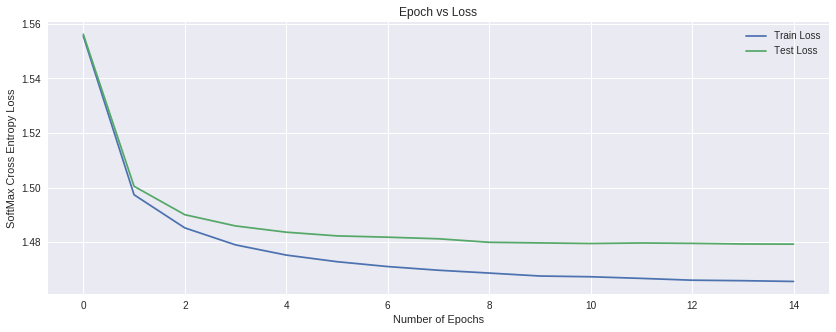

In [65]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


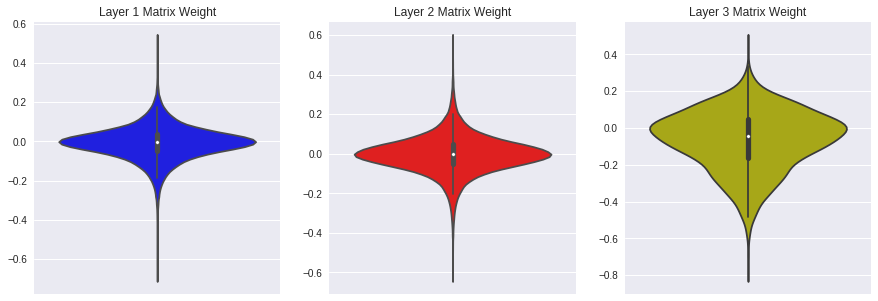

In [66]:
# Sometime a neural net can suffer from vanishing gradient or exploding gradient problem..
# We need to check the weights to see if this is the case with out neural network..
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

plt.show()

#### B) MLP with Batch Normalization

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.048, mean=0)),
    'out' : tf.Variable(tf.random_normal([324, 10] , stddev=0.077, mean=0)) 
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'out' : tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
epsilon = 1e-3
def BatchNormalizedPerceptron(X, weights, biases):
    # Creating Layer 1..
    layer_1 = tf.add( tf.matmul(X, weights['h1']), biases['b1'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_1, var_1 = tf.nn.moments(layer_1, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_1 = tf.Variable(tf.ones([512]))
    beta_1 = tf.Variable(tf.zeros([512]))
    
    # Apply batch normalization now..
    layer_1 = tf.nn.batch_normalization(layer_1, mean_1, var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    #____________________________________________________________________________________________________________
    
    layer_2 = tf.add( tf.matmul(layer_1, weights['h2']), biases['b2'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_2, var_2 = tf.nn.moments(layer_2, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_2 = tf.Variable(tf.ones([324]))
    beta_2 = tf.Variable(tf.zeros([324]))
    
    # Apply batch normalization now..
    layer_2 = tf.nn.batch_normalization(layer_2, mean_2, var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    
    #____________________________________________________________________________________________________________
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)

    return out_layer

In [69]:
# Get predictions
predictions = BatchNormalizedPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.522380854   Test error=1.523296987
Epoch:  02   Train error=1.483134649   Test error=1.488232317
Epoch:  03   Train error=1.475990196   Test error=1.482921649
Epoch:  04   Train error=1.472672578   Test error=1.481789517
Epoch:  05   Train error=1.470383508   Test error=1.479949026
Epoch:  06   Train error=1.469001969   Test error=1.479423040
Epoch:  07   Train error=1.468319122   Test error=1.479112455
Epoch:  08   Train error=1.467566134   Test error=1.478972902
Epoch:  09   Train error=1.466493253   Test error=1.478142568
Epoch:  10   Train error=1.466303635   Test error=1.478355071
Epoch:  11   Train error=1.465547877   Test error=1.477372669
Epoch:  12   Train error=1.465397892   Test error=1.477946306
Epoch:  13   Train error=1.465108864   Test error=1.478302676
Epoch:  14   Train error=1.464983046   Test error=1.477099603
Epoch:  15   Train error=1.464482973   Test error=1.476437337
Accuracy :  0.9836


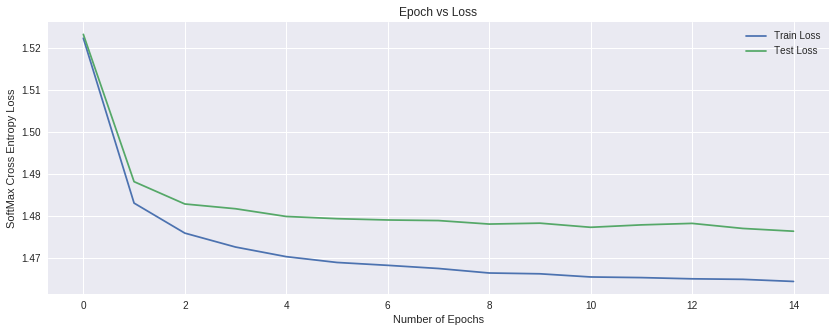

In [70]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


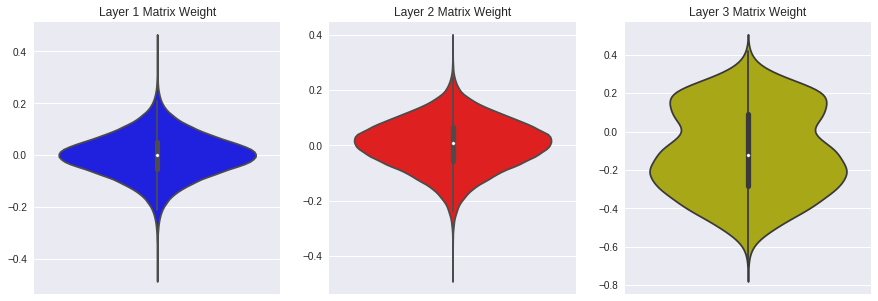

In [71]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

plt.show()

#### C) MLP with DropOut

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.048, mean=0)),
    'out' : tf.Variable(tf.random_normal([324, 10] , stddev=0.077, mean=0)) 
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'out' : tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
def DropoutMLP(X, weights, biases):
    # Using relu activation function..
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, weights['h1']) , biases['b1'] ) )
    # Adding dropout for layer 1 neurons..
    layer_1 = tf.nn.dropout(layer_1, 0.75)
    
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, weights['h2']) , biases['b2'] ) )
    layer_2 = tf.nn.dropout(layer_2, 0.75)
    
    layer_3 = tf.nn.sigmoid( tf.add( tf.matmul(layer_2, weights['out']) , biases['out'] ) )
    return layer_3

In [74]:
# Get predictions
predictions = DropoutMLP(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 1000
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.728500635   Test error=1.723743341
Epoch:  02   Train error=1.557406027   Test error=1.554140819
Epoch:  03   Train error=1.531025943   Test error=1.530080670
Epoch:  04   Train error=1.517829503   Test error=1.517912899
Epoch:  05   Train error=1.508994484   Test error=1.510644676
Epoch:  06   Train error=1.503407400   Test error=1.505478272
Epoch:  07   Train error=1.498014684   Test error=1.501380860
Epoch:  08   Train error=1.494363553   Test error=1.498278932
Epoch:  09   Train error=1.491087534   Test error=1.495974777
Epoch:  10   Train error=1.488499665   Test error=1.494259884
Epoch:  11   Train error=1.486411454   Test error=1.492342420
Epoch:  12   Train error=1.484500729   Test error=1.490772713
Epoch:  13   Train error=1.482928521   Test error=1.489588421
Epoch:  14   Train error=1.481212386   Test error=1.488382602
Epoch:  15   Train error=1.479882360   Test error=1.487419995
Accuracy :  0.9702


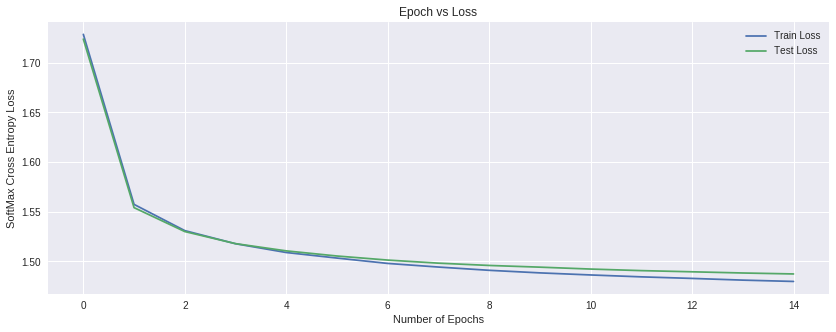

In [75]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


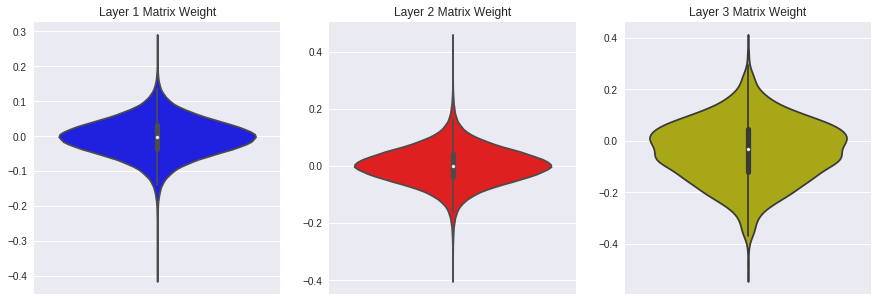

In [76]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

plt.show()

## 2. Three Hidden Layer Model :

** Architecture : ** 784-512-256-64-10

#### A) Simple MLP

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 256], stddev=0.051, mean=0)),
    'h3' : tf.Variable(tf.random_normal([256, 64] , stddev=0.079, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([256])),
    'b3' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
# Input layer placeholders :
X = tf.placeholder(tf.float32, [None, 784])
Y_true = tf.placeholder(tf.float32, [None, 10])

In [0]:
# defining the architecture:
def MultilayerPerceptron(X, w, b):
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, w['h1']), b['b1'] ) )
 
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, w['h2']), b['b2'] ) )
    
    layer_3 = tf.nn.relu( tf.add( tf.matmul(layer_2, w['h3']), b['b3'] ) )
    
    layer_4 = tf.nn.sigmoid( tf.add( tf.matmul(layer_3, w['out']), b['out'] ) )
    
    return layer_4

In [80]:
# Get predictions
predictions = MultilayerPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Run multiple epochs :
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.562745886   Test error=1.565265037
Epoch:  02   Train error=1.495954531   Test error=1.500624210
Epoch:  03   Train error=1.484432717   Test error=1.491106321
Epoch:  04   Train error=1.478963187   Test error=1.486628398
Epoch:  05   Train error=1.475893884   Test error=1.484255735
Epoch:  06   Train error=1.473600376   Test error=1.482466429
Epoch:  07   Train error=1.471315013   Test error=1.481021504
Epoch:  08   Train error=1.470118518   Test error=1.480138658
Epoch:  09   Train error=1.469148852   Test error=1.480343342
Epoch:  10   Train error=1.468219864   Test error=1.479902305
Epoch:  11   Train error=1.467955307   Test error=1.480239404
Epoch:  12   Train error=1.467724093   Test error=1.479957836
Epoch:  13   Train error=1.466918203   Test error=1.479665495
Epoch:  14   Train error=1.466955266   Test error=1.479731837
Epoch:  15   Train error=1.466519575   Test error=1.479041122
Accuracy :  0.9794


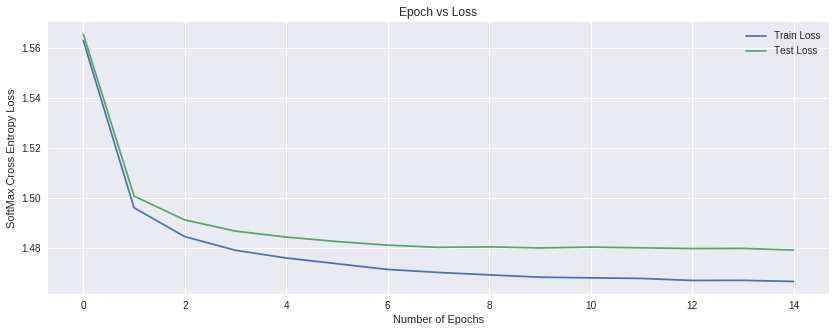

In [81]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


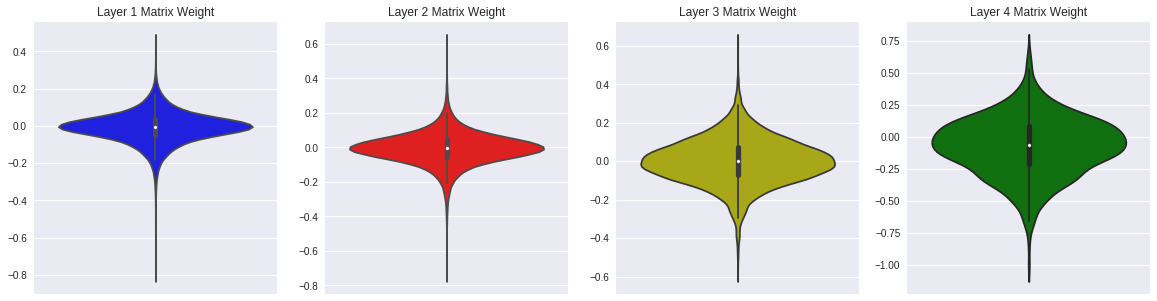

In [82]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

plt.show()

#### B) MLP with Batch Normalization

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 256], stddev=0.051, mean=0)),
    'h3' : tf.Variable(tf.random_normal([256, 64] , stddev=0.079, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([256])),
    'b3' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
epsilon = 1e-3
def BatchNormalizedPerceptron(X, weights, biases):
    # Creating Layer 1..
    layer_1 = tf.add( tf.matmul(X, weights['h1']), biases['b1'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_1, var_1 = tf.nn.moments(layer_1, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_1 = tf.Variable(tf.ones([512]))
    beta_1 = tf.Variable(tf.zeros([512]))
    
    # Apply batch normalization now..
    layer_1 = tf.nn.batch_normalization(layer_1, mean_1, var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    #____________________________________________________________________________________________________________
    
    layer_2 = tf.add( tf.matmul(layer_1, weights['h2']), biases['b2'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_2, var_2 = tf.nn.moments(layer_2, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_2 = tf.Variable(tf.ones([256]))
    beta_2 = tf.Variable(tf.zeros([256]))
    
    # Apply batch normalization now..
    layer_2 = tf.nn.batch_normalization(layer_2, mean_2, var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    
    #____________________________________________________________________________________________________________
    
    layer_3 = tf.matmul(layer_2, weights['h3']) + biases['b3'] 
    
    mean_3, var_3 = tf.nn.moments(layer_3, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_2 = tf.Variable(tf.ones([64]))
    beta_2 = tf.Variable(tf.zeros([64]))
    
    layer_3 = tf.nn.relu(layer_3)
    
    
    out_layer = tf.nn.sigmoid( tf.add( tf.matmul(layer_3, weights['out']), biases['out'] ) )

    return out_layer

In [85]:
# Get predictions
predictions = BatchNormalizedPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.523630319   Test error=1.525616433
Epoch:  02   Train error=1.482071233   Test error=1.487741049
Epoch:  03   Train error=1.475778374   Test error=1.482956654
Epoch:  04   Train error=1.472210028   Test error=1.480794179
Epoch:  05   Train error=1.470786051   Test error=1.479515497
Epoch:  06   Train error=1.469484825   Test error=1.478992223
Epoch:  07   Train error=1.468810306   Test error=1.478873770
Epoch:  08   Train error=1.468079192   Test error=1.478937618
Epoch:  09   Train error=1.466867152   Test error=1.478283349
Epoch:  10   Train error=1.466942925   Test error=1.478106390
Epoch:  11   Train error=1.465875583   Test error=1.477833360
Epoch:  12   Train error=1.465601366   Test error=1.477670797
Epoch:  13   Train error=1.465583734   Test error=1.477722254
Epoch:  14   Train error=1.465290589   Test error=1.477348345
Epoch:  15   Train error=1.464714973   Test error=1.477044913
Accuracy :  0.9817


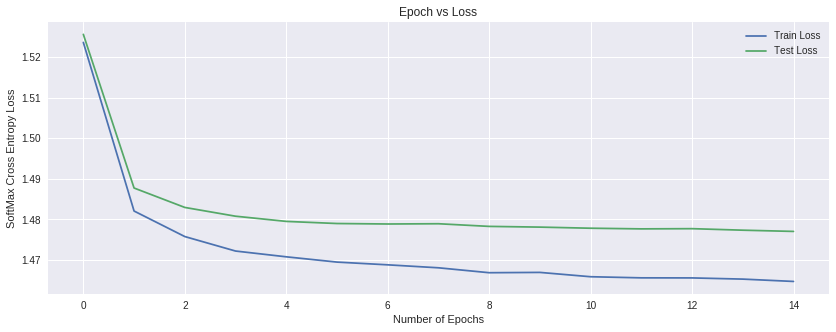

In [86]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


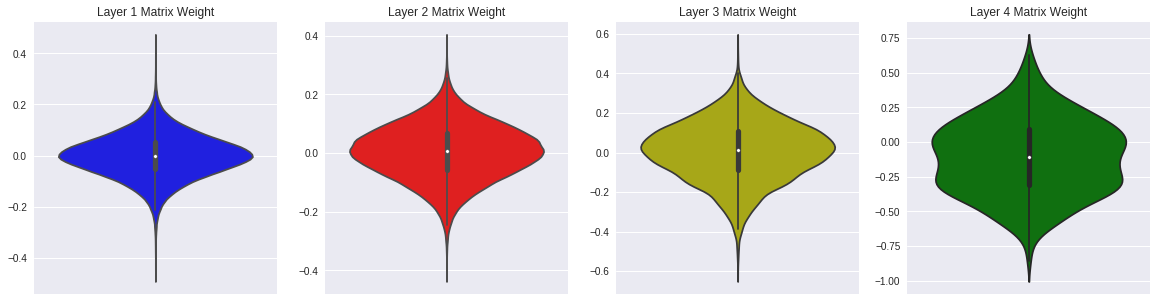

In [87]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

plt.show()

#### C) MLP with Dropout

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 256], stddev=0.051, mean=0)),
    'h3' : tf.Variable(tf.random_normal([256, 64] , stddev=0.079, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([256])),
    'b3' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
def DropoutMLP(X, weights, biases):
    # Using relu activation function..
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, weights['h1']) , biases['b1'] ) )
    # Adding dropout for layer 1 neurons..
    layer_1 = tf.nn.dropout(layer_1, 0.85)
    
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, weights['h2']) , biases['b2'] ) )
    layer_2 = tf.nn.dropout(layer_2, 0.85)
    
    layer_3 = tf.nn.relu( tf.add( tf.matmul(layer_2, weights['h3']) , biases['b3'] ) )
    layer_3 = tf.nn.dropout(layer_3, 0.85)
    
    layer_4 = tf.nn.sigmoid( tf.add( tf.matmul(layer_3, weights['out']) , biases['out'] ) )
    
    return layer_4

In [90]:
# Get predictions
predictions = DropoutMLP(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.582959194   Test error=1.581192413
Epoch:  02   Train error=1.503619512   Test error=1.506031519
Epoch:  03   Train error=1.492315455   Test error=1.495416767
Epoch:  04   Train error=1.486294339   Test error=1.491451495
Epoch:  05   Train error=1.481824970   Test error=1.488433162
Epoch:  06   Train error=1.479671748   Test error=1.485878085
Epoch:  07   Train error=1.476613053   Test error=1.485254626
Epoch:  08   Train error=1.475496215   Test error=1.483862392
Epoch:  09   Train error=1.475266007   Test error=1.483123678
Epoch:  10   Train error=1.473938296   Test error=1.482781445
Epoch:  11   Train error=1.473628079   Test error=1.481625254
Epoch:  12   Train error=1.472218635   Test error=1.481706718
Epoch:  13   Train error=1.472409727   Test error=1.482602194
Epoch:  14   Train error=1.471369559   Test error=1.481416493
Epoch:  15   Train error=1.471398524   Test error=1.481421404
Accuracy :  0.9747


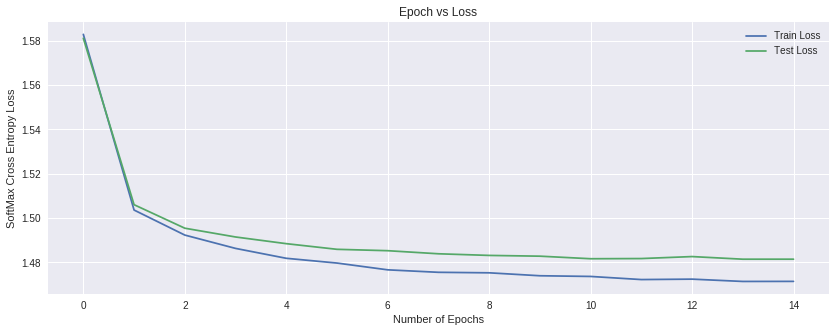

In [91]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


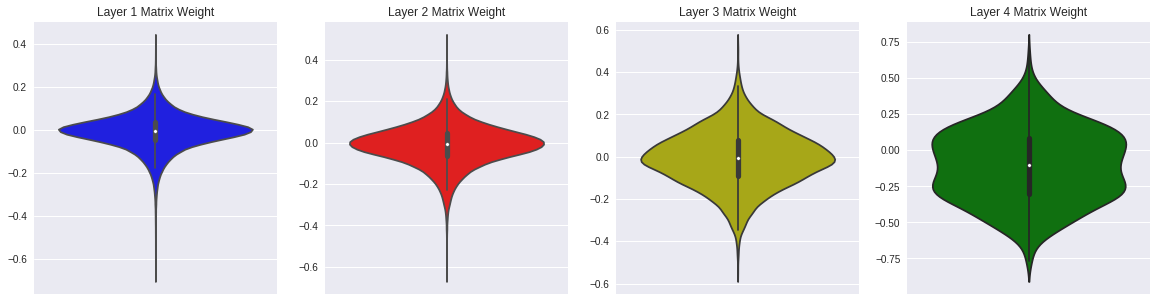

In [92]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

plt.show()

## 3. Five Hidden Layer Model

** Architecture : ** 784-512-324-256-128-64

#### A) Simple MLP

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.055, mean=0)),
    'h3' : tf.Variable(tf.random_normal([324, 256] , stddev=0.058, mean=0)),
    'h4' : tf.Variable(tf.random_normal([256, 128] , stddev=0.072, mean=0)),
    'h5' : tf.Variable(tf.random_normal([128, 64] , stddev=0.102, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'b3' : tf.Variable(tf.random_normal([256])),
    'b4' : tf.Variable(tf.random_normal([128])),
    'b5' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
# Input layer placeholders :
X = tf.placeholder(tf.float32, [None, 784])
Y_true = tf.placeholder(tf.float32, [None, 10])

In [0]:
# defining the architecture:
def MultilayerPerceptron(X, w, b):
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, w['h1']), b['b1'] ) )
 
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, w['h2']), b['b2'] ) )
    
    layer_3 = tf.nn.relu( tf.add( tf.matmul(layer_2, w['h3']), b['b3'] ) )
    
    layer_4 = tf.nn.relu( tf.add( tf.matmul(layer_3, w['h4']), b['b4'] ) )
    
    layer_5 = tf.nn.relu( tf.add( tf.matmul(layer_4, w['h5']), b['b5'] ) )
    
    layer_6 = tf.nn.sigmoid( tf.add( tf.matmul(layer_5, w['out']), b['out'] ) )
    
    return layer_6

In [96]:
# Get predictions
predictions = MultilayerPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Run multiple epochs :
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['h4'].eval()
    l5_w = weights['h5'].eval()
    l6_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.552545957   Test error=1.557220745
Epoch:  02   Train error=1.491701952   Test error=1.497942406
Epoch:  03   Train error=1.484360862   Test error=1.491194288
Epoch:  04   Train error=1.480222683   Test error=1.488261618
Epoch:  05   Train error=1.477749105   Test error=1.486645541
Epoch:  06   Train error=1.477304199   Test error=1.485945355
Epoch:  07   Train error=1.476326681   Test error=1.485167967
Epoch:  08   Train error=1.476166021   Test error=1.486194136
Epoch:  09   Train error=1.475298255   Test error=1.485568386
Epoch:  10   Train error=1.475478291   Test error=1.485328180
Epoch:  11   Train error=1.475396658   Test error=1.487189392
Epoch:  12   Train error=1.474519234   Test error=1.485613456
Epoch:  13   Train error=1.476086500   Test error=1.487539201
Epoch:  14   Train error=1.475254134   Test error=1.485275684
Epoch:  15   Train error=1.477506584   Test error=1.486541192
Accuracy :  0.967


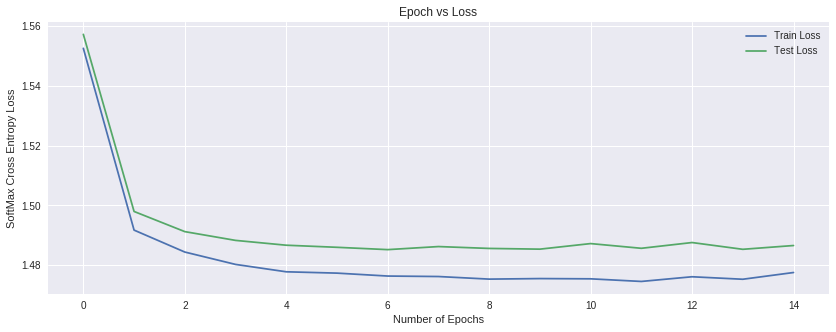

In [97]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


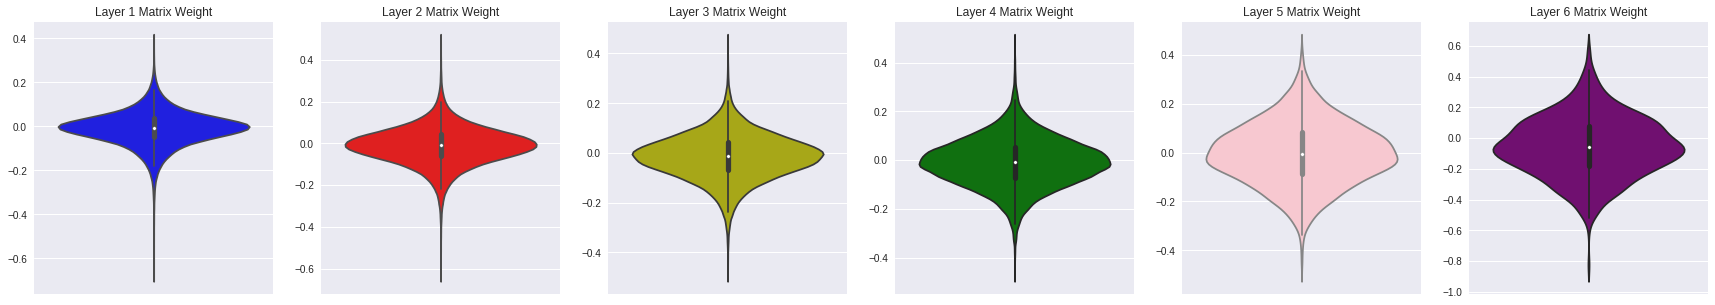

In [98]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)
l5_w = l5_w.flatten().reshape(-1, 1)
l6_w = l6_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

ax5.set_title("Layer 5 Matrix Weight")
sns.violinplot(y=l5_w, color = 'pink', ax=ax5)

ax6.set_title("Layer 6 Matrix Weight")
sns.violinplot(y=l6_w, color = 'purple', ax=ax6)

plt.show()

#### B) BatchNormalized MLP

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.055, mean=0)),
    'h3' : tf.Variable(tf.random_normal([324, 256] , stddev=0.058, mean=0)),
    'h4' : tf.Variable(tf.random_normal([256, 128] , stddev=0.072, mean=0)),
    'h5' : tf.Variable(tf.random_normal([128, 64] , stddev=0.102, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'b3' : tf.Variable(tf.random_normal([256])),
    'b4' : tf.Variable(tf.random_normal([128])),
    'b5' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
epsilon = 1e-3
def BatchNormalizedPerceptron(X, weights, biases):
    # Creating Layer 1..
    layer_1 = tf.add( tf.matmul(X, weights['h1']), biases['b1'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_1, var_1 = tf.nn.moments(layer_1, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_1 = tf.Variable(tf.ones([512]))
    beta_1 = tf.Variable(tf.zeros([512]))
    
    # Apply batch normalization now..
    layer_1 = tf.nn.batch_normalization(layer_1, mean_1, var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    #____________________________________________________________________________________________________________
    
    layer_2 = tf.add( tf.matmul(layer_1, weights['h2']), biases['b2'] )
    
    # Calculating the mean and variance of weights to apply batch normalization..
    # tf.nn.moments calculates the mean and variance of the tensor passed.
    mean_2, var_2 = tf.nn.moments(layer_2, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_2 = tf.Variable(tf.ones([324]))
    beta_2 = tf.Variable(tf.zeros([324]))
    
    # Apply batch normalization now..
    layer_2 = tf.nn.batch_normalization(layer_2, mean_2, var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    
    #____________________________________________________________________________________________________________
    
    layer_3 = tf.matmul(layer_2, weights['h3']) + biases['b3'] 
    
    mean_3, var_3 = tf.nn.moments(layer_3, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_2 = tf.Variable(tf.ones([256]))
    beta_2 = tf.Variable(tf.zeros([256]))
    
    layer_3 = tf.nn.relu(layer_3)
    
    
    
    
    layer_4 = tf.matmul(layer_3, weights['h4']) + biases['b4'] 
    
    mean_4, var_4 = tf.nn.moments(layer_4, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_4 = tf.Variable(tf.ones([128]))
    beta_4 = tf.Variable(tf.zeros([128]))
    
    layer_4 = tf.nn.relu(layer_4)
    
    
    
    layer_5 = tf.matmul(layer_4, weights['h5']) + biases['b5'] 
    
    mean_5, var_5 = tf.nn.moments(layer_5, [0]) # [0] gives the axis i.e the column wise mean and variance.
    
    # Parameters for batch normalization
    scale_5 = tf.Variable(tf.ones([64]))
    beta_5 = tf.Variable(tf.zeros([64]))
    
    layer_5 = tf.nn.relu(layer_5)
    
    
    out_layer = tf.nn.sigmoid( tf.add( tf.matmul(layer_5, weights['out']), biases['out'] ) )

    return out_layer

In [101]:
# Get predictions
predictions = BatchNormalizedPerceptron(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['h4'].eval()
    l5_w = weights['h5'].eval()
    l6_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.519288975   Test error=1.522476138
Epoch:  02   Train error=1.485463546   Test error=1.490058502
Epoch:  03   Train error=1.480771061   Test error=1.485753513
Epoch:  04   Train error=1.478125117   Test error=1.484648012
Epoch:  05   Train error=1.477675273   Test error=1.484428349
Epoch:  06   Train error=1.477075309   Test error=1.483307330
Epoch:  07   Train error=1.476391282   Test error=1.482753442
Epoch:  08   Train error=1.476221920   Test error=1.482644656
Epoch:  09   Train error=1.475237719   Test error=1.481803026
Epoch:  10   Train error=1.476091782   Test error=1.482313262
Epoch:  11   Train error=1.474750432   Test error=1.481912018
Epoch:  12   Train error=1.476906968   Test error=1.483469230
Epoch:  13   Train error=1.475586104   Test error=1.482401869
Epoch:  14   Train error=1.475226091   Test error=1.482258302
Epoch:  15   Train error=1.476958841   Test error=1.484025229
Accuracy :  0.9723


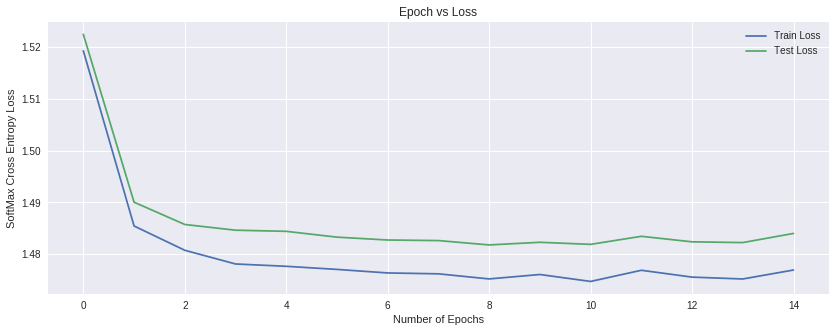

In [102]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


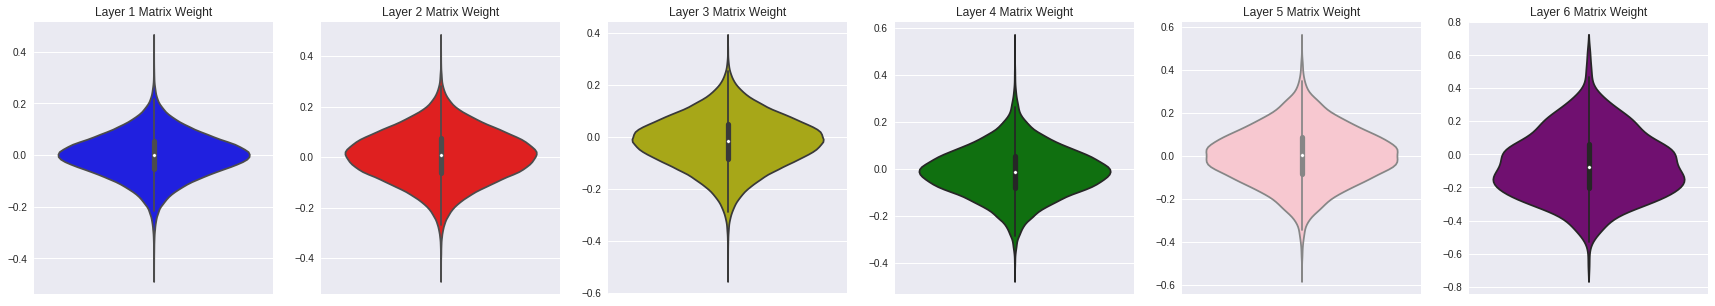

In [103]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)
l5_w = l5_w.flatten().reshape(-1, 1)
l6_w = l6_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

ax5.set_title("Layer 5 Matrix Weight")
sns.violinplot(y=l5_w, color = 'pink', ax=ax5)

ax6.set_title("Layer 6 Matrix Weight")
sns.violinplot(y=l6_w, color = 'purple', ax=ax6)

plt.show()

#### C) MLP with DropOut

In [0]:
# Layer Weights and Biases :

weights = {
    'h1' : tf.Variable(tf.random_normal([784, 512], stddev=0.039, mean=0)), 
    'h2' : tf.Variable(tf.random_normal([512, 324], stddev=0.055, mean=0)),
    'h3' : tf.Variable(tf.random_normal([324, 256] , stddev=0.058, mean=0)),
    'h4' : tf.Variable(tf.random_normal([256, 128] , stddev=0.072, mean=0)),
    'h5' : tf.Variable(tf.random_normal([128, 64] , stddev=0.102, mean=0)),
    'out': tf.Variable(tf.random_normal([64, 10] , stddev=0.164, mean=0))
}

biases = {
    'b1' : tf.Variable(tf.random_normal([512])), 
    'b2' : tf.Variable(tf.random_normal([324])),
    'b3' : tf.Variable(tf.random_normal([256])),
    'b4' : tf.Variable(tf.random_normal([128])),
    'b5' : tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([10]))
}
mnist = inp_data

In [0]:
def DropoutMLP(X, weights, biases):
    # Using relu activation function..
    layer_1 = tf.nn.relu( tf.add( tf.matmul(X, weights['h1']) , biases['b1'] ) )
    # Adding dropout for layer 1 neurons..
    layer_1 = tf.nn.dropout(layer_1, 0.75)
    
    layer_2 = tf.nn.relu( tf.add( tf.matmul(layer_1, weights['h2']) , biases['b2'] ) )
    layer_2 = tf.nn.dropout(layer_2, 0.75)
    
    layer_3 = tf.nn.relu( tf.add( tf.matmul(layer_2, weights['h3']) , biases['b3'] ) )
    layer_3 = tf.nn.dropout(layer_3, 0.75)
    
    layer_4 = tf.nn.relu( tf.add( tf.matmul(layer_3, weights['h4']) , biases['b4'] ) )
    layer_4 = tf.nn.dropout(layer_4, 0.75)
    
    layer_5 = tf.nn.relu( tf.add( tf.matmul(layer_4, weights['h5']) , biases['b5'] ) )
    layer_5 = tf.nn.dropout(layer_5, 0.75)
    
    layer_6 = tf.nn.sigmoid( tf.add( tf.matmul(layer_5, weights['out']) , biases['out'] ) )
    
    return layer_6

In [106]:
# Get predictions
predictions = DropoutMLP(X, weights, biases)

# Calculate Multiclass Logistsics Loss using labels and predictions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=Y_true))

# Reduce the loss using AdamOptimizer..
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # This is similar to declaring variables to be used.
    sess.run(tf.global_variables_initializer())
    
    # For plotting we store error for train and test for each epoch
    train_error = []
    test_error = []
    epoch_counter = []
    # Select batch size and compute total number of batches in the epoch.
    batch_size = 100
    total_batches = int(mnist.train.num_examples/batch_size)
    
    # Define number of epochs.
    num_epochs = 15
    
    
    for epoch in range(num_epochs):
        train_avg_cost = 0.0
        test_avg_cost = 0.0
        batchnum = 0
        for i in range(total_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run the optimizer for this batch calculate errors and store in the list. It also returns train error (loss)
            sess.run(optimizer, feed_dict={X: batch_x, Y_true: batch_y})
            loss_batch = sess.run(loss, feed_dict={X: batch_x, Y_true: batch_y})
            train_avg_cost += loss_batch/total_batches
            
            # Compute loss for test set
            loss_test = sess.run(loss, feed_dict={X: mnist.test.images, Y_true: mnist.test.labels})
            test_avg_cost += loss_test/total_batches
            
        if(epoch % 1 == 0):
            print("Epoch: ", "%02d" % (epoch+1),"  Train error={:.9f}".format(train_avg_cost),"  Test error={:.9f}".format(test_avg_cost))
        # Append losses for this current epoch
        train_error.append(train_avg_cost)
        test_error.append(test_avg_cost)
        epoch_counter.append(epoch)
        
    # Get final accuracy on test after training ...
    l1_w = weights['h1'].eval()
    l2_w = weights['h2'].eval()
    l3_w = weights['h3'].eval()
    l4_w = weights['h4'].eval()
    l5_w = weights['h5'].eval()
    l6_w = weights['out'].eval()
    
    correct_predictions = tf.equal( tf.argmax(predictions, 1), tf.argmax(Y_true, 1) )
    accuracy = tf.reduce_mean( tf.cast(correct_predictions, tf.float32) )
    # accuracy.eval is similar to sess.run(accuracy)
    print("Accuracy : ", accuracy.eval(feed_dict={X: mnist.test.images, Y_true: mnist.test.labels}) )
    sess.close()

Epoch:  01   Train error=1.649136835   Test error=1.646288021
Epoch:  02   Train error=1.527880364   Test error=1.528641305
Epoch:  03   Train error=1.511907047   Test error=1.513089358
Epoch:  04   Train error=1.505248455   Test error=1.507807418
Epoch:  05   Train error=1.501761289   Test error=1.506287369
Epoch:  06   Train error=1.499942586   Test error=1.503012320
Epoch:  07   Train error=1.499667525   Test error=1.502075277
Epoch:  08   Train error=1.498519781   Test error=1.502727295
Epoch:  09   Train error=1.498233475   Test error=1.502037319
Epoch:  10   Train error=1.496951008   Test error=1.500561210
Epoch:  11   Train error=1.497662403   Test error=1.501759943
Epoch:  12   Train error=1.498817705   Test error=1.502974052
Epoch:  13   Train error=1.500456986   Test error=1.505399111
Epoch:  14   Train error=1.497528642   Test error=1.501639939
Epoch:  15   Train error=1.498105382   Test error=1.502659803
Accuracy :  0.9332


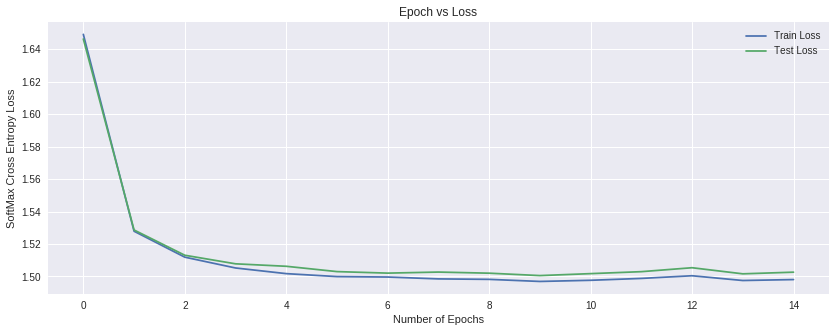

In [107]:
# display training and test accuracy curves vs epochs..
plt.figure(figsize=(14,5))
plt.title("Epoch vs Loss")
plt.ylabel("SoftMax Cross Entropy Loss")
plt.xlabel("Number of Epochs")
plt.plot(epoch_counter, train_error, label="Train Loss")
plt.plot(epoch_counter, test_error, label="Test Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


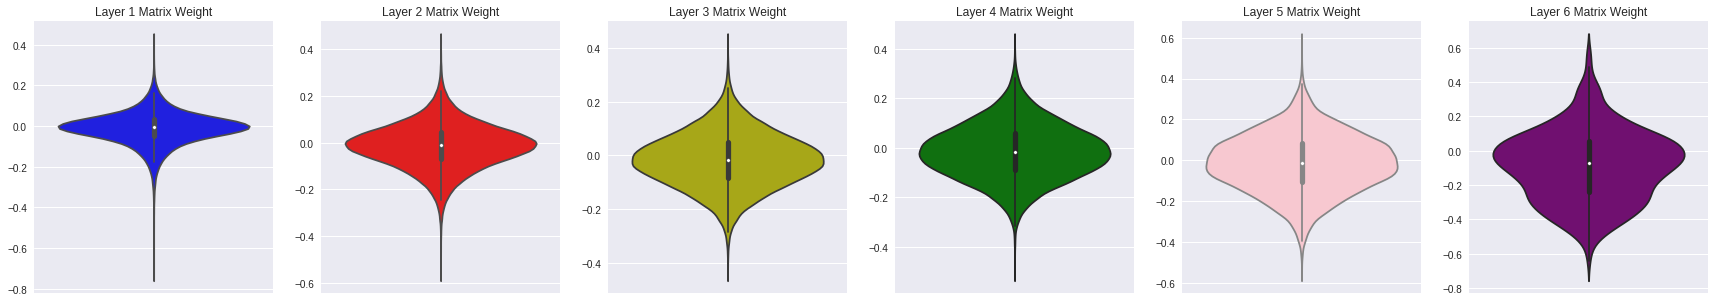

In [108]:
l1_w = l1_w.flatten().reshape(-1, 1)
l2_w = l2_w.flatten().reshape(-1, 1)
l3_w = l3_w.flatten().reshape(-1, 1)
l4_w = l4_w.flatten().reshape(-1, 1)
l5_w = l5_w.flatten().reshape(-1, 1)
l6_w = l6_w.flatten().reshape(-1, 1)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30,5))
ax1.set_title("Layer 1 Matrix Weight")
sns.violinplot(y=l1_w, color = 'b', ax=ax1)

ax2.set_title("Layer 2 Matrix Weight")
sns.violinplot(y=l2_w, color = 'r', ax=ax2)

ax3.set_title("Layer 3 Matrix Weight")
sns.violinplot(y=l3_w, color = 'y', ax=ax3)

ax4.set_title("Layer 4 Matrix Weight")
sns.violinplot(y=l4_w, color = 'g', ax=ax4)

ax5.set_title("Layer 5 Matrix Weight")
sns.violinplot(y=l5_w, color = 'pink', ax=ax5)

ax6.set_title("Layer 6 Matrix Weight")
sns.violinplot(y=l6_w, color = 'purple', ax=ax6)

plt.show()

5 Hidden Layers ----

Train error=1.477506584   Test error=1.486541192
Accuracy :  0.967

Train error=1.476958841   Test error=1.484025229
Accuracy :  0.9723

Train error=1.498105382   Test error=1.502659803
Accuracy :  0.9332


# Results :

<table>
    <tr>
        <th rowspan="2">Count of Hidden Layers</th><th colspan ="3">Simple MLP</th> <th colspan ="3">BatchNormalized MLP</th> <th colspan ="3">Dropout MLP</th>
    </tr>
    <tr>
        <th>Train error</th><th>Test error</th><th>Accuracy</th><th>Train error</th><th>Test error</th><th>Accuracy</th><th>Train error</th><th>Test error</th><th>Accuracy</th>
    </tr>
    <tr>
        <td>2</td><td>1.4656</td><td>1.4793</td><td>97.74</td><td>1.4644</td><td>1.4764</td><td style="color:green; font-weight:bold">98.36</td><td>1.4798</td><td>1.4874</td><td>97.02</td>
    </tr>
    
    <tr>
        <td>3</td><td>1.4665</td><td>1.4790</td><td>97.94</td><td>1.4647</td><td>1.4770</td><td>98.17</td><td>1.4713</td><td>1.4814</td><td>97.47</td>
    </tr>
    
    <tr>
        <td>5</td><td>1.4775</td><td>1.4865</td><td>96.7</td><td>1.4769</td><td>1.4840</td><td>97.23</td><td>1.4981</td><td>1.5026</td><td>93.32</td>
    </tr>
    
</table>

<br>
Results obtained with following parameters -

1. Number of epochs were kept constant at 15 epochs.
2. The batch size taken is same for all the models - 100.
3. Learning rate for all the models was also kept constant at 0.001.
4. ReLu activation function was used.